# NX-421 Mini Project — Group P, Variant 1 (PCA) with Preprocessing 

## GLM Only



## 4. GLM

### 4a. Import: 

Load libraries: 

In [28]:

# Data handling and visualization imports
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy.linalg as npl


# NiLearn imports
#%pip install nilearn
# %pip install nibabel
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix
from nilearn import plotting
from nilearn.reporting import get_clusters_table
from nilearn.image import mean_img, get_data, coord_transform
from nilearn.glm import threshold_stats_img
from nilearn import datasets, image, plotting
from nilearn.reporting import get_clusters_table
from nilearn.image import coord_transform


Load base imagine: functional (motion corrected and smoothed):

In [3]:
img_path = "/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/fMRI_project/moco_smoothed-4mm.nii" ### TO BE REPLACED WITH YOUR PATH ###

img = nib.load(img_path)

Check the TR, number of scans, and estimate scan duration for reference:

In [4]:
TR = 0.72
n_scans = img.shape[-1]
scan_dur = n_scans * TR

print("Number of Scans:", n_scans, "Scan Duration (s):", scan_dur)

Number of Scans: 568 Scan Duration (s): 408.96


Load event files:

In [5]:
ev_LR_path = "/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/fMRI_project/subject101410/fMRI/tfMRI_MOTOR_LR/events_LR.csv"
ev_RL_path = "/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/fMRI_project/subject101410/fMRI/tfMRI_MOTOR_RL/events_RL.csv"
ev_LR = pd.read_csv(ev_LR_path) # in the functional preprocessing step for concatenation LR is placed first before RL
ev_RL = pd.read_csv(ev_RL_path)

Clean event files:

In [6]:

# 1) Ensure onset and duration are numeric
for df in (ev_LR, ev_RL):
    df["onset"] = pd.to_numeric(df["onset"], errors="coerce")
    df["duration"] = pd.to_numeric(df["duration"], errors="coerce")

# 2) Change condition column name for trial-type
ev_LR = ev_LR.rename(columns={"condition": "trial_type"})
ev_RL = ev_RL.rename(columns={"condition": "trial_type"})

# 3) Fill NaN values in trial_type with 'rest'
ev_LR["trial_type"] = ev_LR["trial_type"].fillna("rest")
ev_RL["trial_type"] = ev_RL["trial_type"].fillna("rest")

Adjust onset of the second run, to ensure smooth concatenation:

In [7]:
# 1) Observe that the RL run onsets need to be adjusted by adding the duration of the LR run
n_scans_run1 = n_scans // 2         # 284
dur_run1 = n_scans_run1 * TR        # 204.48 s

print("Run 1 duration (s):", dur_run1)

# 2) Adjust RL onset
ev_RL['onset'] += dur_run1 # shift to follow Run 1 on timeline

Run 1 duration (s): 204.48


### 4c. Task Matrix

Concatenate runs:

In [8]:
# 1) Combine the two event files into one run

events_1 = pd.concat([ev_LR, ev_RL], ignore_index=True)

# 2) Check concatenated events
events_1 ## almost exactly 408s

,onset,duration,trial_type
0,0.00,8.0,rest
1,8.00,3.0,cue
2,11.00,12.0,rh
3,23.00,3.0,cue
4,26.00,12.0,lf
5,38.00,3.0,cue
6,41.00,12.0,t
7,53.00,3.0,cue
8,56.00,12.0,rf
9,68.00,3.0,cue


## 5. First Level Model

### 5a. Set up GLM 

** 4. Run the GLM at the level you deem reasonable**


Answer: We run the GLM at the FIRST level. We only have one subject so it is not possible to run a second level model.

Note volumes that were identified during preprocessing as outliers:

In [9]:
volumes_to_remove = [0, 1, 9, 11, 16, 17, 35, 36, 39, 41, 43, 44, 45, 46, 49, 50, 57, 58, 61, 63, 120, 121, 146, 150, 283, 566]

Create initial GLM design:

(568, 12) ['cue', 'fixation', 'lf', 'lh', 'rest', 'rf', 'rh', 't', 'drift_1', 'drift_2', 'drift_3', 'constant']


<Axes: label='conditions', ylabel='scan number'>

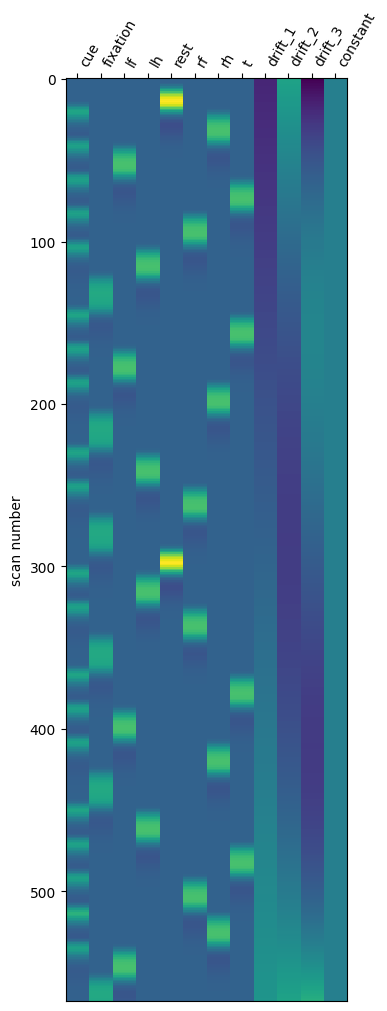

In [10]:
# 1) Create initial glm: 

glm = FirstLevelModel(
    t_r=TR, # Repetition time
    noise_model='ar1',  # AR(1) noise model
    standardize=False,
    hrf_model='spm', # SPM HRF
    high_pass=.01,
    drift_model='polynomial', # adding drft terms
    drift_order=3, # 3rd order polynomial
).fit(img_path, events_1)

design = glm.design_matrices_[0]
print(design.shape, list(design.columns))
plot_design_matrix(design)

Include motion outliers as regressors to remove noise:


/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/134414405.py:10: UserWarning: If design matrices are supplied, [drift_model, t_r] will be ignored.
  glm_noise_removed.fit(img_path, design_matrices=[design_mat_regged])


(568, 38) ['cue', 'fixation', 'lf', 'lh', 'rest', 'rf', 'rh', 't', 'drift_1', 'drift_2', 'drift_3', 'constant']


<Axes: label='conditions', ylabel='scan number'>

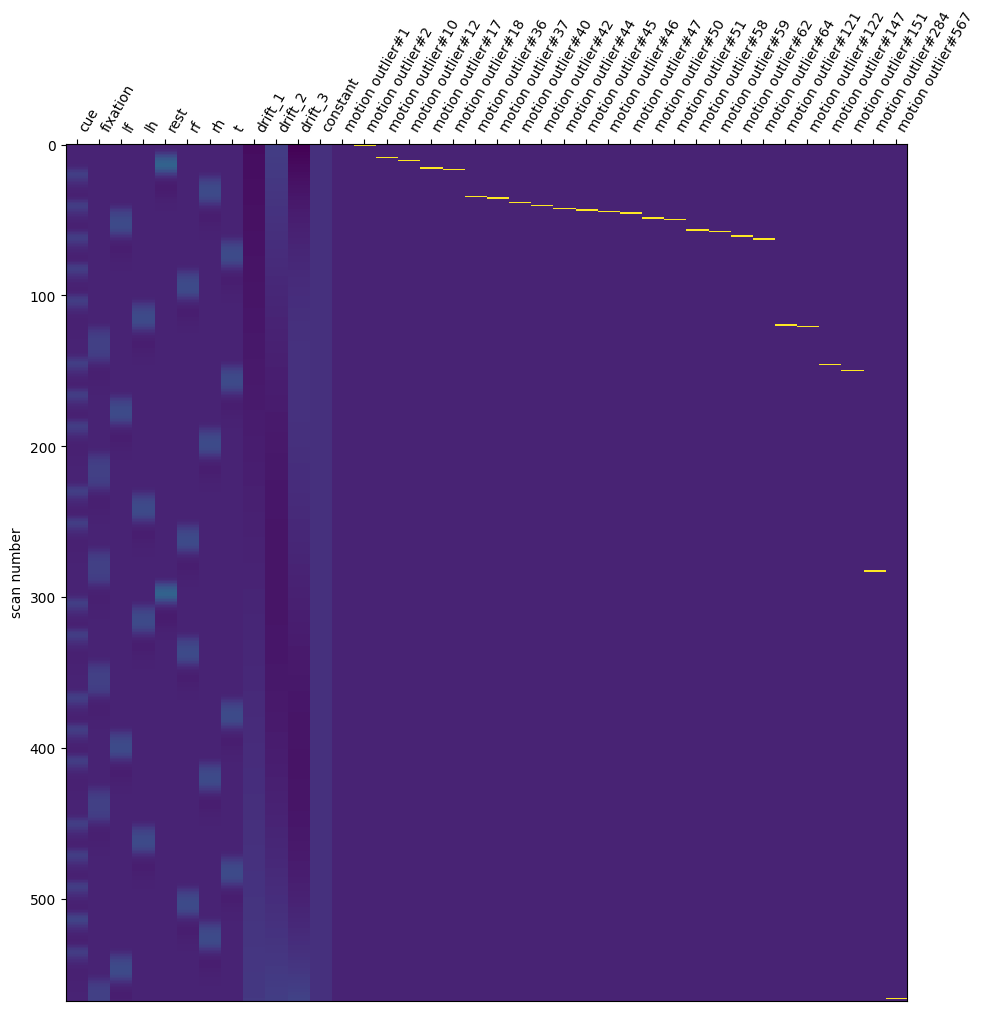

In [11]:
# 2) Add motion outlier regressors to design matrix: 
design_mat_regged = design.copy()

for i in volumes_to_remove:
    reg = np.zeros((284*2,))*0.0
    reg[i] = 1.0
    design_mat_regged['motion outlier#' + str(i+1)] = reg

glm_noise_removed = FirstLevelModel(t_r=TR, drift_model='None')
glm_noise_removed.fit(img_path, design_matrices=[design_mat_regged])

new_design = glm_noise_removed.design_matrices_[0]
print(new_design.shape, list(design.columns))
plot_design_matrix(new_design)

** 3. Report the experimental design matrix to use for this subject, which you will be using in the following GLM analysis.**

Answer: The design matrix included eight task-related regressors (cue, rest, fixation, left/right hand, left/right foot, and tongue), three polynomial drift terms,  one constant, and 26 motion outliers.
Drift regressors modeled low-frequency trends in the BOLD signal. 
Idenfied motion outliers during preprocessing and modeled them using a binary regressors, allowing for variance to be isolated from task activity

### 5b. Check Drift (check)

In [ ]:
drift_cols = [col for col in new_design.columns if 'drift' in col]
print("Drift columns:", drift_cols)


In [ ]:
import os
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_stat_map

bg = mean_img(img_path)
folder_state_path = 'derivatives/GLM/drift_z_maps'
os.makedirs(folder_state_path, exist_ok=True)

for drift in drift_cols:
    z_map = glm_noise_removed.compute_contrast(drift, output_type="z_score")

    plot_stat_map(z_map, bg_img=bg, threshold=3.0, display_mode='x',
                  cut_coords=np.linspace(-40,40,8), black_bg=False,
                  title=f'{drift} Z-map')
    file_name = f"{drift}_z_map_uncorrected.nii.gz"
    nib.save(z_map, os.path.join(folder_state_path, file_name))
    plt.savefig(os.path.join(folder_state_path, f"{drift}_z_map.png"))
    plt.show()


### 5c. Statistical Maps: Task Related Regressors

 ** 4. Report the statistical maps of each of the task-related regressors. Briefly comment on the statistical maps and, if you can, relate them to the corresponding task. **
 Answer: The statistical maps show significant activations above the set threshold approx z > 3. 

Regressor LH (Left Hand) — y = -18: Shows activation primarily in the right hemisphere, perhaps in the right motor cortex (precentral gyrus). 
This is consistent with contralateral motor control, as movement or stimulation of the left hand is processed in the right motor areas.
However, the activations occur also in other areas, which are not uniquely involved with left hand motor activity. 

Regressor RH (Right Hand) — y = -24: Shows activations are found predominantly in the left motor cortex, again aligning with contralateral representation of motor control. But like before, there are activations that extend the regions uniquely involved with right hand motor activity. 

Regressor Tongue — y = -2: The map shows bilateral activation with clusters close to the inferior precentral gyrus and insula, extending toward primary motor and somatosensory areas responsible for orofacial movements. This is expected since tongue movement tends to produce bilateral activation, reflecting its midline representation and bilateral innervation.

Regressor Cue — z = -3: This map shows more diffuse and lower-intensity activations, particularly in occipital and temporal regions. These may correspond to visual and attentional processing linked to cue presentation. The lack of strong lateralization or focal activation suggests that the cue regressor captures perceptual or preparatory processes rather than motor execution.


Set p-value and z-score threshold for statistical tests:

In [12]:
# 1) Determine z-score threshold for significance 
p_value = 0.001
z_score_threshold = norm.isf(p_value)

print(z_score_threshold) # 3.09 z for a p value of 0.001

3.090232306167813


Plotting task-related regressors: 

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/3926736729.py:5: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_image = mean_img(img)


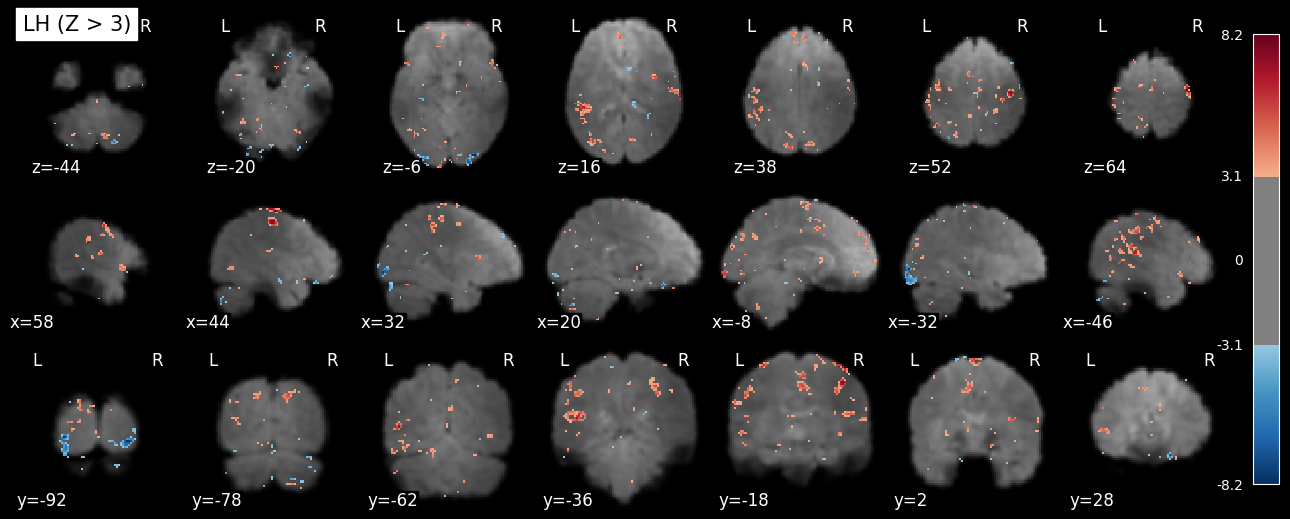

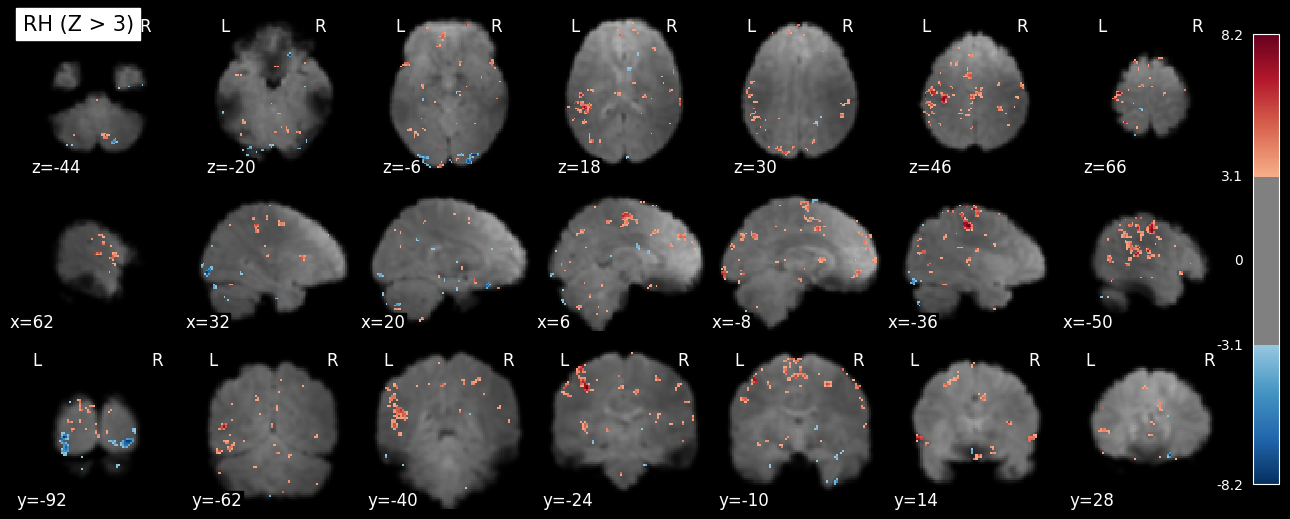

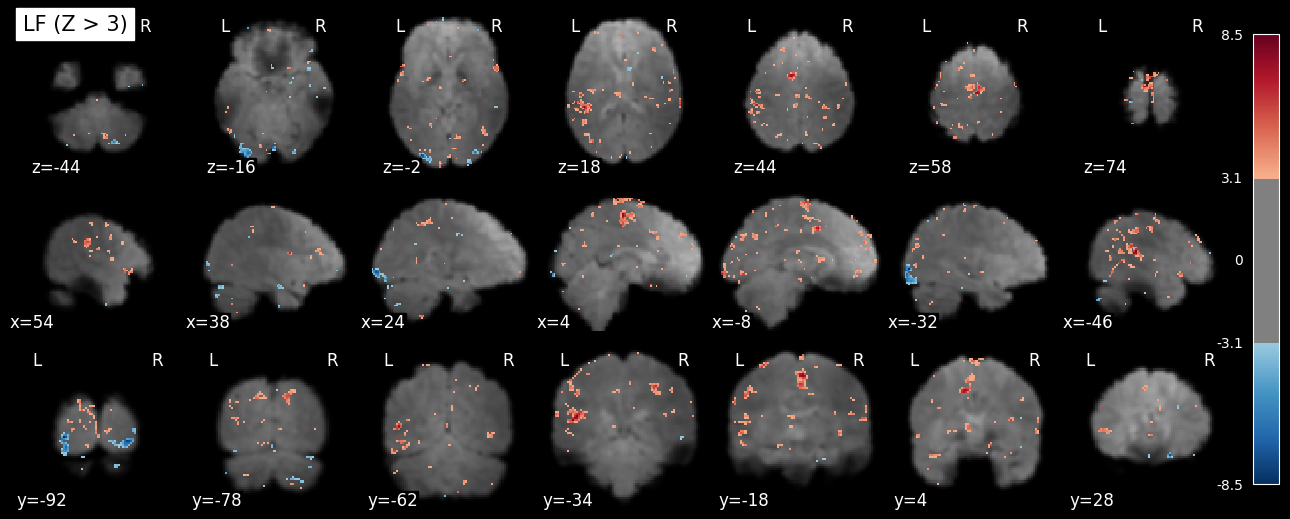

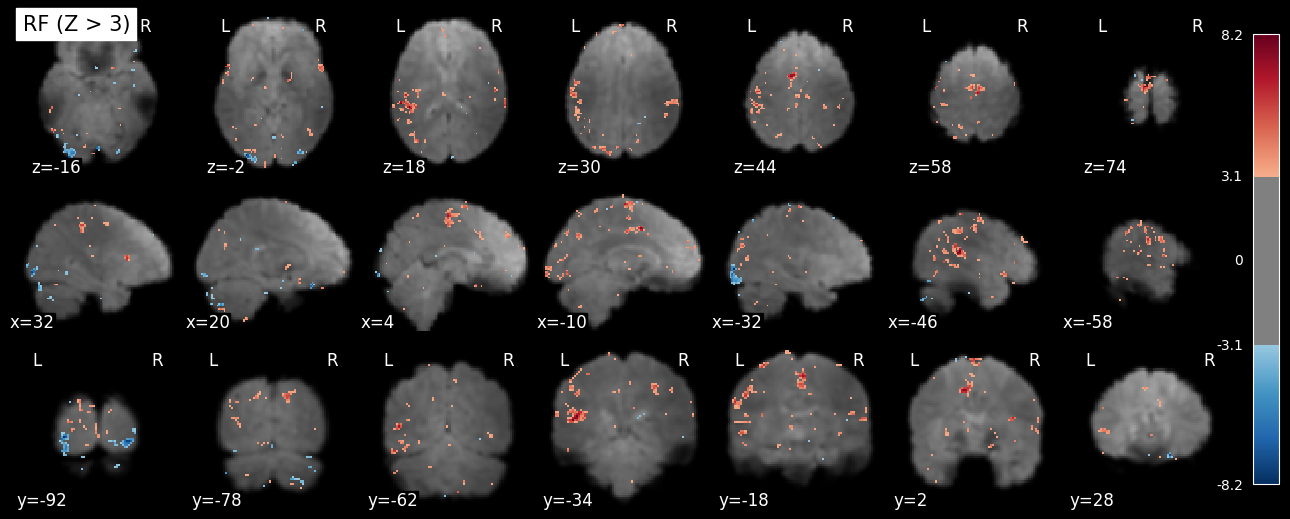

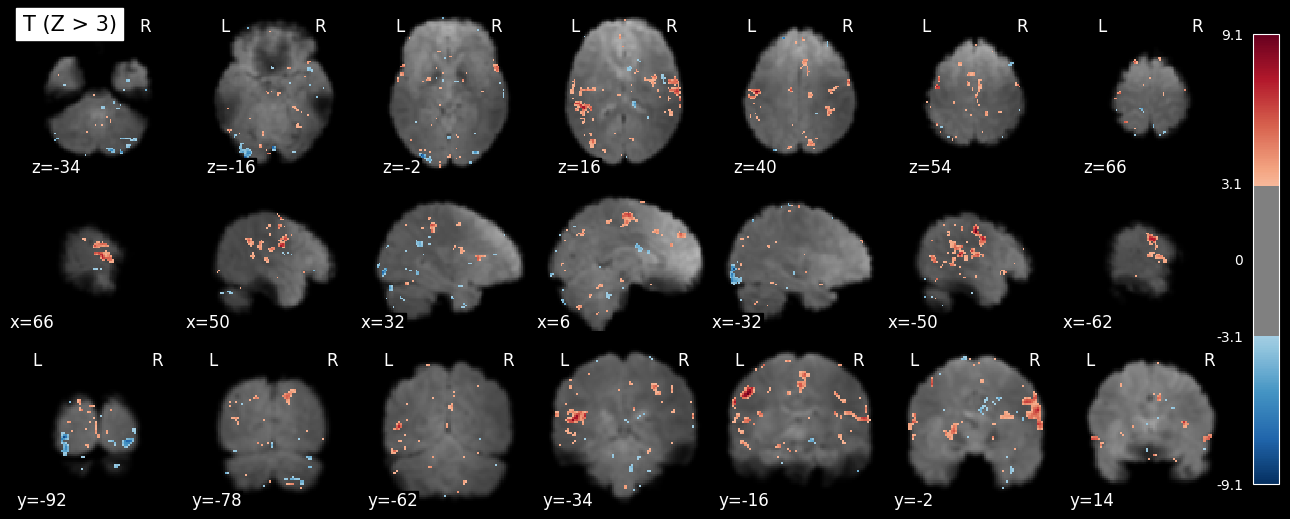

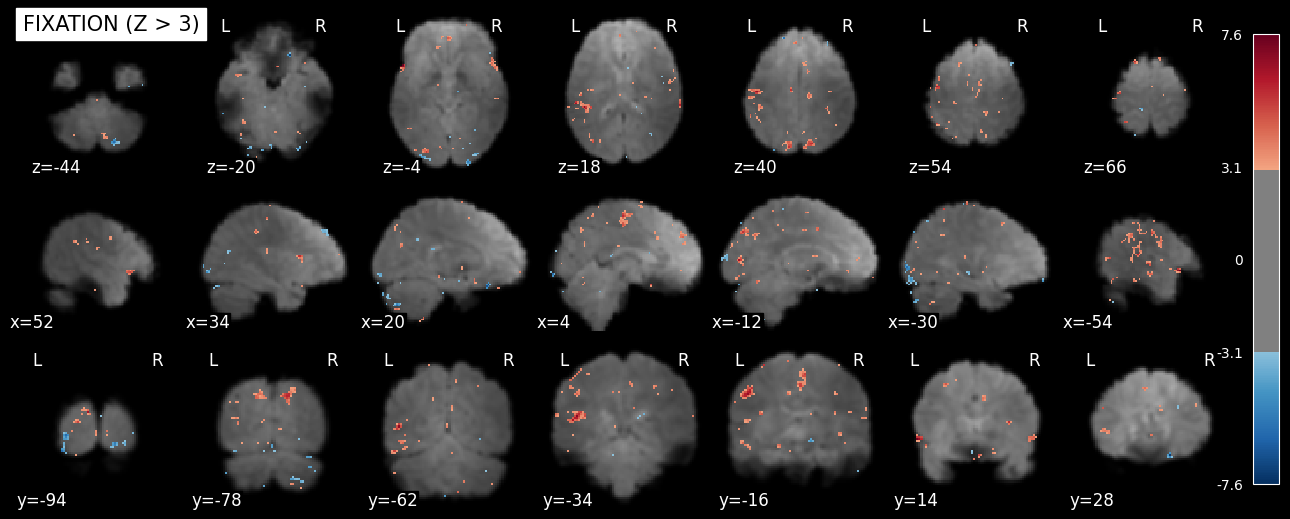

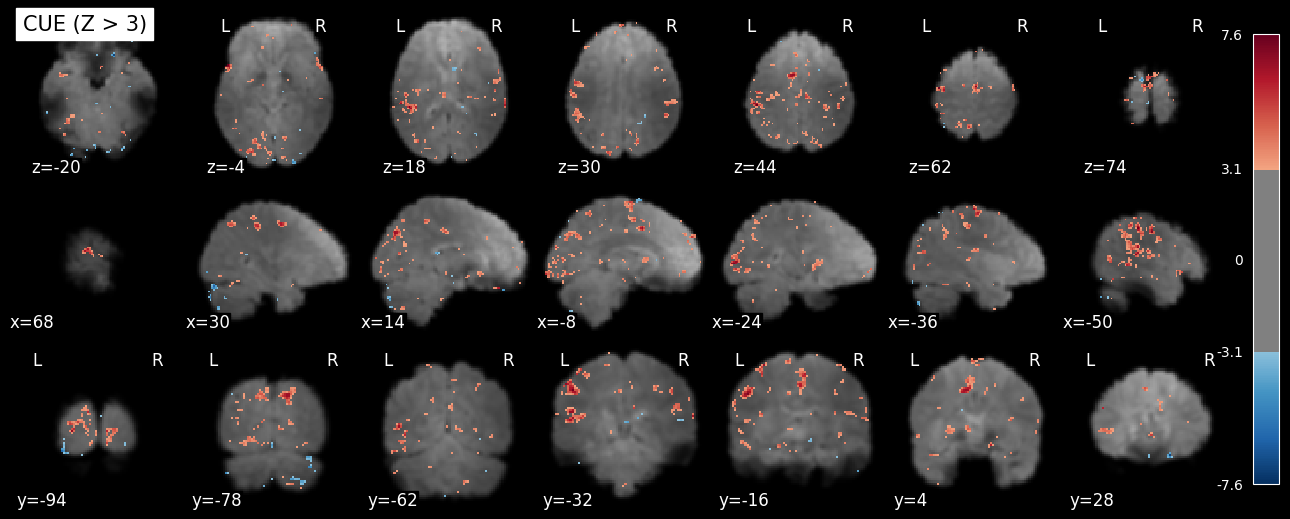

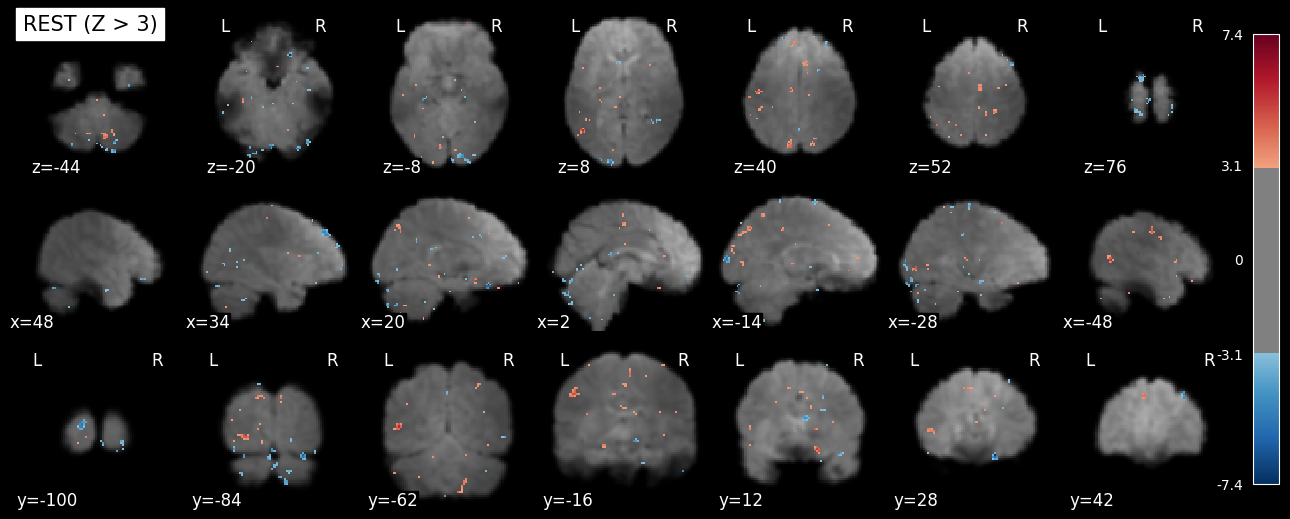

In [13]:
# 1) Define trial types
trial_types = ['lh', 'rh', 'lf', 'rf', 't', 'fixation', 'cue', 'rest']

# 2) Compute mean image for background
mean_image = mean_img(img) 


# 3) Loop over each trial type column to create and plot statistical maps
for cond in trial_types:
    # Compute statistical map for this condition/regressor
    z_map = glm_noise_removed.compute_contrast(cond, output_type="z_score")
    
    # Plot statistical map for the condition
    plotting.plot_stat_map(
        z_map, 
        bg_img= mean_image, 
        display_mode='mosaic', 
         black_bg= True,
        threshold=z_score_threshold,  
        title=f"{cond.upper()} (Z > 3)"
    )


For the presentation, include some isoaled examples: 

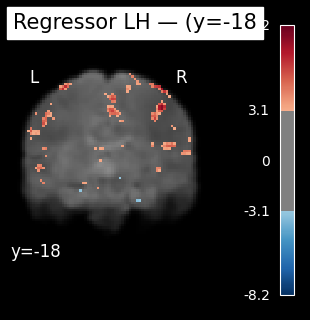

In [14]:
# 1) Left Hand  

y =  -18  # y coordinate in MNI space 

# Compute LH contrast map: 
lh_map = glm_noise_removed.compute_contrast('lh', output_type='z_score')

# Plot LH map at specified y coordinate: 
plotting.plot_stat_map(
    lh_map,
    bg_img=mean_image,
    threshold=z_score_threshold,              
    display_mode="y",         
    cut_coords=[y],               
    draw_cross=False,             
    black_bg=True,
    annotate=True,
    title=f"Regressor LH — (y={y}")

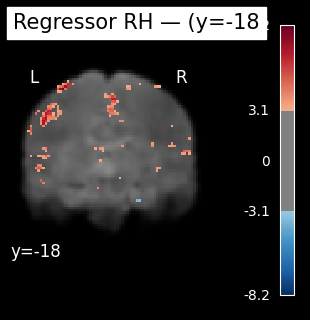

In [15]:
# 2) Right Hand  

y =  -18 # y coordinate in MNI space

# Compute RH contrast map: 
rh_map = glm_noise_removed.compute_contrast('rh', output_type='z_score')

# Plot RH map at specified y coordinate:
plotting.plot_stat_map(
    rh_map,
    bg_img=mean_image,
    threshold=z_score_threshold,              
    display_mode="y",         
    cut_coords=[y],              
    draw_cross=False,             
    black_bg=True,
    annotate=True,
    title=f"Regressor RH — (y={y}")

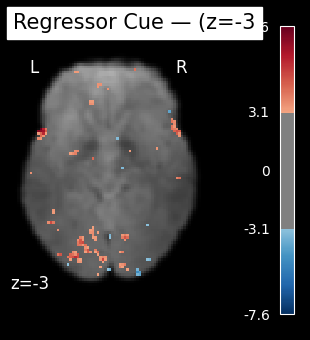

In [16]:
# 3) Cue  

z =  -3 # z coordinate in MNI space

# Compute Cue contrast map:
cue_map = glm_noise_removed.compute_contrast('cue', output_type='z_score')

# Plot Cue map at specified z coordinate:
plotting.plot_stat_map(
    cue_map,
    bg_img=mean_image,
    threshold=z_score_threshold,              
    display_mode="z",         
    cut_coords=[z],               
    draw_cross=False,             
    black_bg=True,
    annotate=True,
    title=f"Regressor Cue — (z={z}")

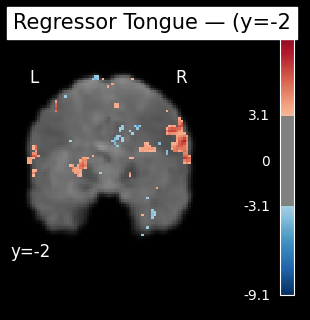

In [17]:
# 4) Tongue 

y =  -2  # y coordinate in MNI space

# Compute Tongue contrast map: 
t_map = glm_noise_removed.compute_contrast('t', output_type='z_score')

# Plot Tongue map at specified y coordinate:
plotting.plot_stat_map(
    t_map,
    bg_img=mean_image,
    threshold=z_score_threshold,              
    display_mode="y",         
    cut_coords=[y],               
    draw_cross=False,             
    black_bg=True,
    annotate=True,
    title=f"Regressor Tongue — (y={y}")

## 6. Contrasts

** 5. Using the results of the GLM analysis and a contrast vector of your choice, create the activation maps corresponding to the hand motion against feet motion. Please include in the report the contrast vector used and the contrast map you obtained. **

Answer: We ran two contrasts (which are the opposite of one another):

Hands (average left and right) > Feet (average left and right):
(LR + RH)/2  -   (LF+RF)/2

We produce statistical maps for activations that are uncorrected, and subsequently, those that are corrected for multiple comparisons using FDR and cluster filtering:

We choose to show one slice across different maps for consistency.

Hands > Feet contrast (slice y = -18):

•	Activation patterns:  Bilateral clusters are observed in the precentral gyrus (primary motor cortex, M1) and postcentral gyrus (primary somatosensory cortex, S1).

•	Lateralization: The activations are stronger in the lateral portions of the motor cortex, consistent with the somatotopic organization of M1, where hand and arm representations are located more laterally, while foot representations are medial.

•	Deactivations (blue regions): Found near the medial wall, corresponding to supplementary motor and foot-related regions, which show greater activity for foot movement relative to hand movement.



In [18]:

# 1) Hands(avg) > Feet(avg) 
avg_hands_vs_avg_feet = glm_noise_removed.compute_contrast(
    "(lh + rh)/2 - (lf + rf)/2",
    output_type="z_score"
)

# Additional (opposite of 1) : Feet(avg) > Hands(avg) -- to extract regions that are involved in foot movement
avg_feet_vs_avg_hands = glm_noise_removed.compute_contrast(
    "(lf + rf)/2 - (lh + rh)/2",
    output_type="z_score"
)

## 7. Statistical maps:

#### 7a. Uncorrected statistical maps: 

##### Hands > Feet: Mosaic

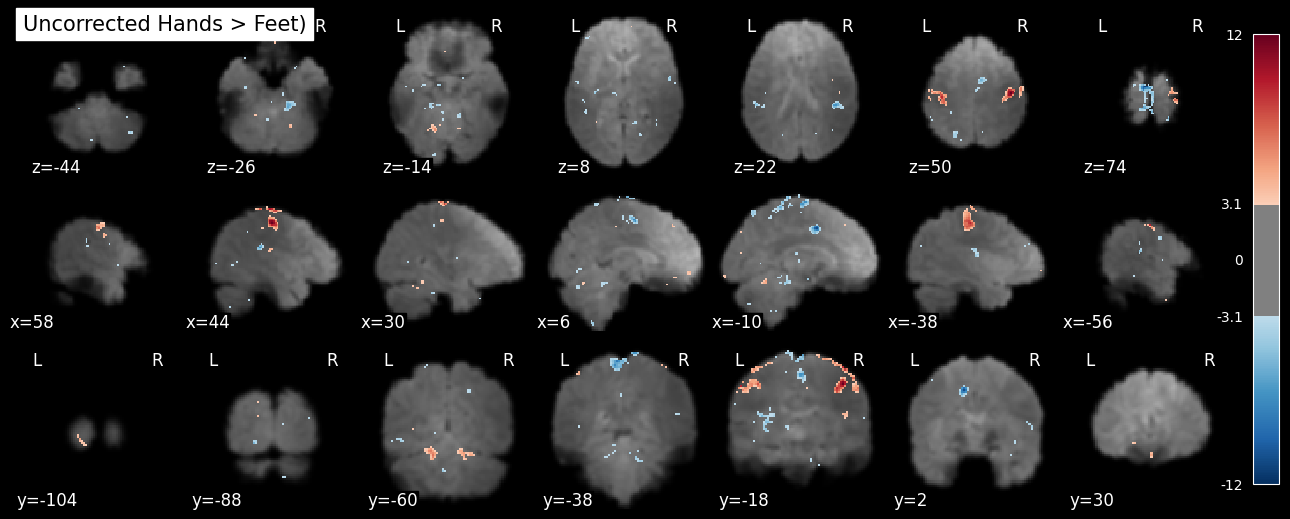

In [19]:
# Hands > Feet Mosaic:
 
plotting.plot_stat_map(
    avg_hands_vs_avg_feet,       
    bg_img=mean_image,
    threshold=z_score_threshold,              
    display_mode="mosaic",             
    draw_cross=False,            
    black_bg=True,
    annotate=True,         
    title=f"Uncorrected Hands > Feet)"
)

##### Hands > Feet: Only coronal y = -18

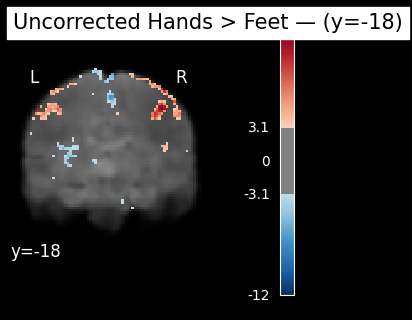

In [20]:

y = -18                           

plotting.plot_stat_map(
    avg_hands_vs_avg_feet,       
    bg_img=mean_image,
    threshold=z_score_threshold,              
    display_mode="y",             
    cut_coords=[y],              
    draw_cross=False,            
    black_bg=True,
    annotate=True,
            
    title=f"Uncorrected Hands > Feet — (y={y})"
)

##### Feet > Hand: Mosaic

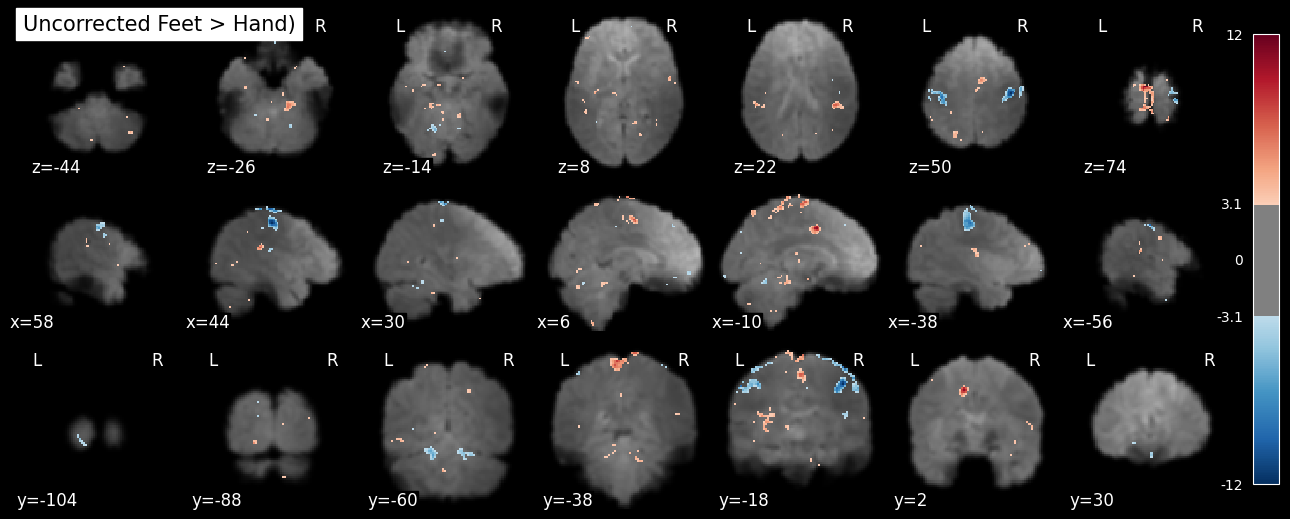

In [21]:

plotting.plot_stat_map(
    avg_feet_vs_avg_hands,       
    bg_img=mean_image,
    threshold=z_score_threshold,              
    display_mode="mosaic",                           
    draw_cross=False,            
    black_bg=True,
    annotate=True,          
    title=f"Uncorrected Feet > Hand)"
)

##### Feet > Hands: Only coronal y = -18

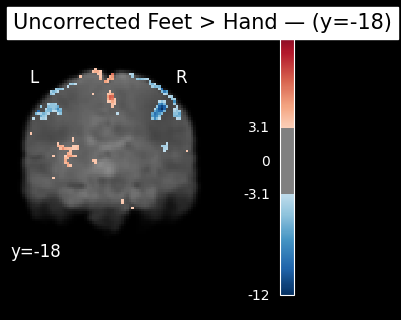

In [22]:

y = -18                      
     
plotting.plot_stat_map(
    avg_feet_vs_avg_hands,       
    bg_img=mean_image,
    threshold=z_score_threshold,              
    display_mode="y",             
    cut_coords=[y],              
    draw_cross=False,            
    black_bg=True,
    annotate=True,             
    title=f"Uncorrected Feet > Hand — (y={y})"
)

#### 7b. FDR and Cluster Corrected Plots

FDR correction and cluster: 

In [23]:
from nilearn.plotting import plot_stat_map
from nilearn.glm import threshold_stats_img

# 1) Define FDR rate and cluster size
fdr_rate = 0.05 
cluster_size = 10

##### Hands > Feet: Mosaic

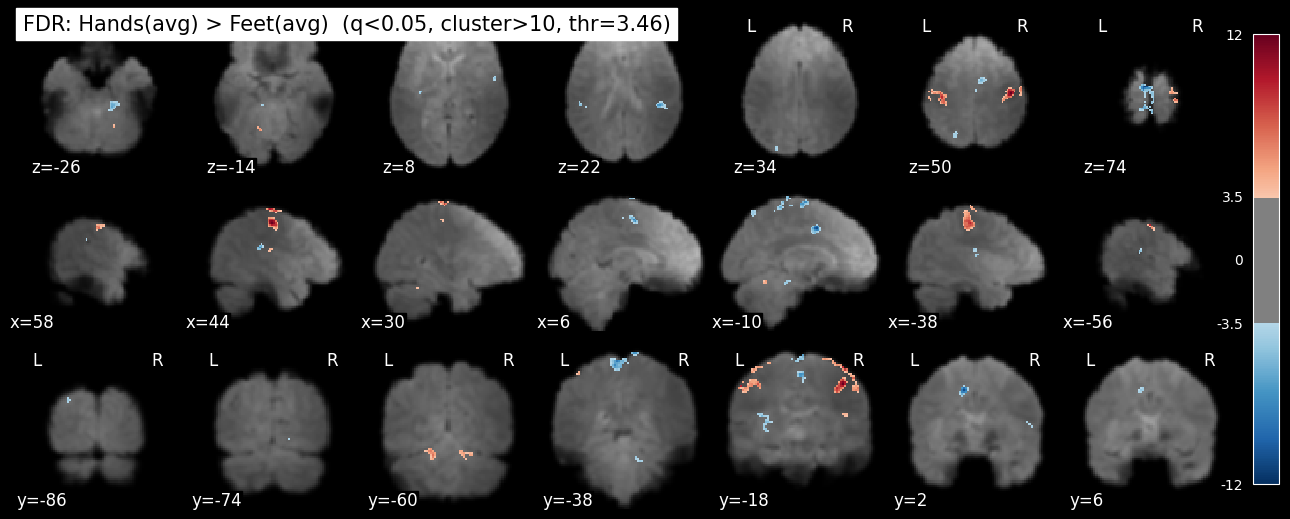

In [24]:
# Hands > Feet Mosaic:

# 1) FDR & cluster thresholding
hands_clean, hands_fdr = threshold_stats_img(
    avg_hands_vs_avg_feet, alpha=fdr_rate, height_control='fdr',
    cluster_threshold=cluster_size, two_sided=True
)

# 2) Plot FDR & cluster thresholded map
plot_stat_map(
    hands_clean,
    bg_img=mean_image,
    threshold=hands_fdr,
    display_mode='mosaic',
    black_bg=True,
    annotate=True,
    title=f"FDR: Hands(avg) > Feet(avg)  (q<{fdr_rate}, cluster>{cluster_size}, thr={hands_fdr:.2f})",
)

##### Hands > Feet: Coronal only y=-18

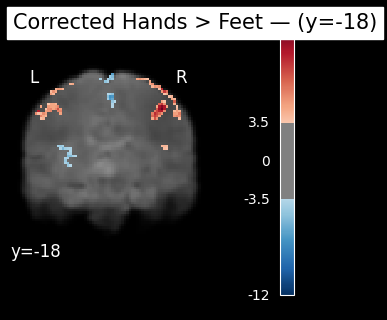

In [25]:
y = -18                           
     
plotting.plot_stat_map(
    hands_clean,       
    bg_img=mean_image,
    threshold=hands_fdr,              
    display_mode="y",             
    cut_coords=[y],              
    draw_cross=False,            
    black_bg=True,
    annotate=True,             
    title=f"Corrected Hands > Feet — (y={y})"
)

##### Feet > Hands: Mosaic

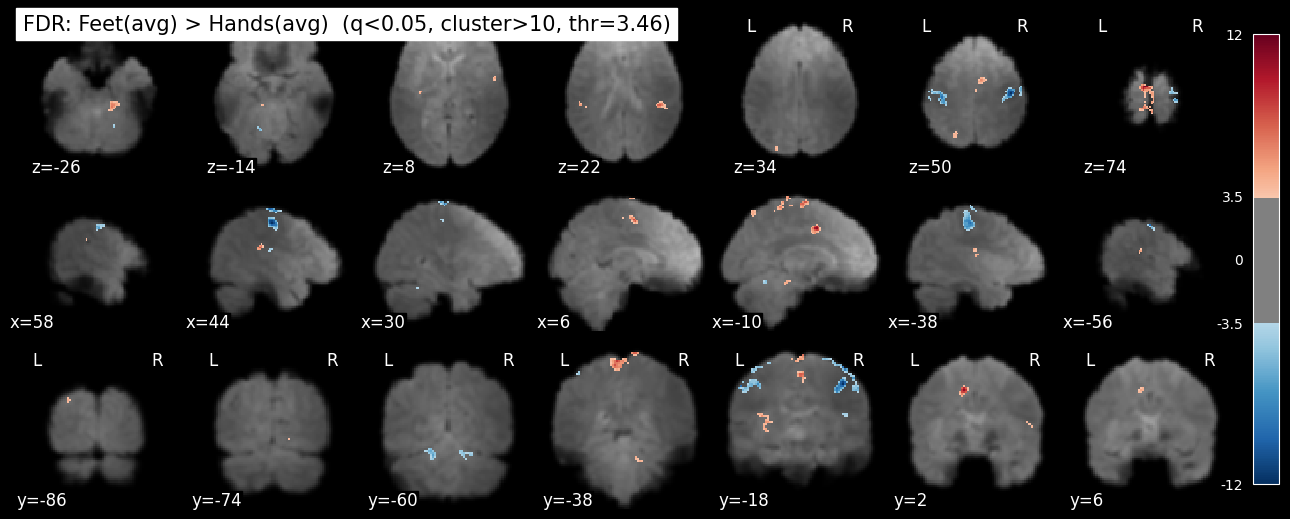

In [26]:

#  1) FDR & cluster thresholding
feet_clean, feet_fdr = threshold_stats_img(
    avg_feet_vs_avg_hands, alpha=fdr_rate, height_control='fdr',
    cluster_threshold=cluster_size, two_sided=True
)

# 2) Mosaic: 
plot_stat_map(
    feet_clean,
    bg_img=mean_image,
    threshold=feet_fdr,
    display_mode= 'mosaic',
    black_bg=True,
    annotate=True,
    title=f"FDR: Feet(avg) > Hands(avg)  (q<{fdr_rate}, cluster>{cluster_size}, thr={feet_fdr:.2f})", 
)

##### Feet > Hands: Coronal only y=-18

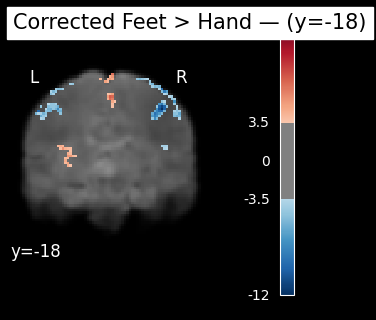

In [27]:
y = -18                           

# Corrected Feet > Hand map ---
plotting.plot_stat_map(
    feet_clean,       
    bg_img=mean_image,
    threshold=feet_fdr,              
    display_mode="y",             
    cut_coords=[y],              
    draw_cross=False,            
    black_bg=True,
    annotate=True,             
    title=f"Corrected Feet > Hand — (y={y})"
)

### 7c. Peak Clusters

** 6. To better interpret your results, overlay the contrast map with the AAL atlas parcellation (hint: take a look at NiLearn). Report in which brain regions you find maximal contrast. **

Answer: 

For Hands > Feet:

The strongest activations were observed bilaterally in the primary motor cortex (Precentral gyrus) and primary somatosensory cortex (Postcentral gyrus), extending into the superior parietal lobule and cerebellum. These regions are well known to be involved in voluntary hand movement and proprioceptive feedback. Additional cerebellar activation in lobule VI likely reflects coordination and fine motor control during hand movements.

For  Feet > Hands:
Significant activations were observed in medial motor regions, particularly the supplementary motor area (SMA), paracentral lobule, and mid-cingulate cortex, extending to the insula and cerebellum.These activations cluster around medial sensorimotor regions, consistent with the foot representation area in the paracentral lobule and SMA. Bilateral cerebellar activation again suggests the contribution of motor coordination and balance mechanisms engaged during lower limb movements.

In [29]:

# 1) Fetch AAL and resample to stat map grid
aal = datasets.fetch_atlas_aal(version="SPM12")
aal_img = image.load_img(aal.maps)
aal_resampled = image.resample_to_img(aal_img, avg_hands_vs_avg_feet, interpolation="nearest")
aal_data = np.asarray(aal_resampled.dataobj).astype(int)

# 2) Build index and label dict
aal_indices = [int(i) for i in aal.indices]
aal_labels  = list(aal.labels)
idx2label   = {i: lab for i, lab in zip(aal_indices, aal_labels)}

# 3) Coordinate: AAL label helper 
def aal_label_from_xyz(x, y, z):
    i, j, k = np.round(coord_transform(x, y, z, npl.inv(aal_resampled.affine))).astype(int)
    if (i < 0 or j < 0 or k < 0 or
        i >= aal_data.shape[0] or j >= aal_data.shape[1] or k >= aal_data.shape[2]):
        return "Out of bounds", (i, j, k)
    code = int(aal_data[i, j, k])
    if code == 0:
        return "Background", (i, j, k)
    return idx2label.get(code, f"Unknown({code})"), (i, j, k)

# 4) Label your peaks
def label_xyz_row(row):
    lab, _ = aal_label_from_xyz(row["X"], row["Y"], row["Z"])
    return lab


/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/2008694387.py:2: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  aal = datasets.fetch_atlas_aal(version="SPM12")


[fetch_atlas_aal] Dataset found in /Users/pamelavandenenden/nilearn_data/aal_SPM12


/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/2008694387.py:4: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  aal_resampled = image.resample_to_img(aal_img, avg_hands_vs_avg_feet, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/2008694387.py:4: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  aal_resampled = image.resample_to_img(aal_img, avg_hands_vs_avg_feet, interpolation="nearest")


#### Hands > Feet

In [30]:

peaks_hand = get_clusters_table(avg_hands_vs_avg_feet, stat_threshold=3.0, cluster_threshold=10)
main_peaks_hand = (peaks_hand[peaks_hand["Cluster Size (mm3)"].notna()]
                   .sort_values("Peak Stat", ascending=False)
                   .copy())
main_peaks_hand["AAL_Label"] = main_peaks_hand.apply(label_xyz_row, axis=1)

print("\nHands > Feet (top 20):")
print(main_peaks_hand[["Cluster ID","X","Y","Z","Peak Stat","Cluster Size (mm3)","AAL_Label"]]
      .head(20).to_string(index=False))



Hands > Feet (top 20):
Cluster ID     X      Y     Z  Peak Stat Cluster Size (mm3)     AAL_Label
         1  44.0  -18.0  50.0  12.300909               2032  Precentral_R
         2  36.0  -28.0  70.0  11.061923               2232  Precentral_R
        2a  46.0  -16.0  64.0  10.465249                     Precentral_R
        1a  38.0  -20.0  44.0   9.640701                     Precentral_R
         3 -56.0  -18.0  48.0   9.571704               3336 Postcentral_L
        1b  36.0  -26.0  54.0   9.302044                     Precentral_R
        2b  52.0  -22.0  58.0   9.292479                    Postcentral_R
        3a -38.0  -22.0  50.0   9.252367                    Postcentral_L
        2c  30.0  -22.0  72.0   8.478881                     Precentral_R
        3b -58.0  -16.0  44.0   7.917407                    Postcentral_L
        3c -44.0  -16.0  48.0   6.797371                    Postcentral_L
         4 -14.0  -60.0 -20.0   6.650524                856 Cerebelum_6_L
         5 -44

#### Feet > Hands

In [31]:
peaks_feet = get_clusters_table(
    avg_feet_vs_avg_hands, stat_threshold=3.0, cluster_threshold=10
)
main_peaks_feet = (peaks_feet[peaks_feet["Cluster Size (mm3)"].notna()]
                   .sort_values("Peak Stat", ascending=False)
                   .copy())
main_peaks_feet["AAL_Label"] = main_peaks_feet.apply(label_xyz_row, axis=1)

print("\nFeet > Hands (top 40):")
print(main_peaks_feet[["Cluster ID","X","Y","Z","Peak Stat","Cluster Size (mm3)","AAL_Label"]].head(40).to_string(index=False))


Feet > Hands (top 40):
Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)            AAL_Label
         1  -6.0 -10.0  74.0  11.349601               4944    Supp_Motor_Area_L
         2 -10.0   2.0  44.0  10.991999                672       Cingulum_Mid_L
        1a  -6.0 -38.0  72.0   8.740638                    Paracentral_Lobule_L
        1b -12.0 -14.0  72.0   8.420004                    Paracentral_Lobule_L
         3  10.0 -40.0  80.0   8.172249                160        Postcentral_R
         4   6.0  -6.0  54.0   8.088750                568    Supp_Motor_Area_R
        1c  -8.0 -38.0  68.0   7.971748                    Paracentral_Lobule_L
         5  44.0 -32.0  22.0   7.402846               1376      Rolandic_Oper_R
         6 -36.0 -20.0  18.0   6.540651               1088             Insula_L
         7  18.0 -34.0 -26.0   6.533638               1080        Cerebelum_3_R
         8  54.0   0.0  10.0   6.047525                152      Rolandic_Oper_R
         9 -18.0

### 7d. Atlas Superposition 

#### Hands > Feet

##### Highest Peak: Precentral R

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/4083501273.py:1: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  aal_resampled_hands = image.resample_to_img(aal_img, hands_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/4083501273.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  aal_resampled_hands = image.resample_to_img(aal_img, hands_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/4083501273.py:16: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' param

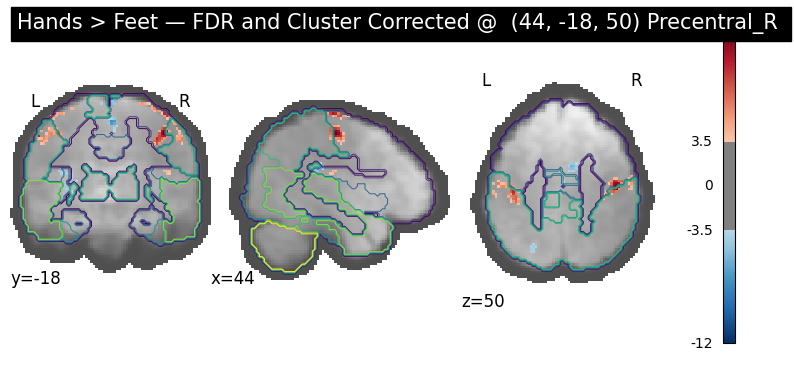

In [32]:
aal_resampled_hands = image.resample_to_img(aal_img, hands_clean, interpolation="nearest")

# Precentral_R peak at (44, -18, 50)
display = plotting.plot_stat_map(
    hands_clean,
    bg_img=mean_image,
    threshold=hands_fdr,
    display_mode='ortho',         
    cut_coords=(44, -18, 50), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Hands > Feet — FDR and Cluster Corrected @  (44, -18, 50) Precentral_R "

)
display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)

#####  Precentral L

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/3522794123.py:14: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)


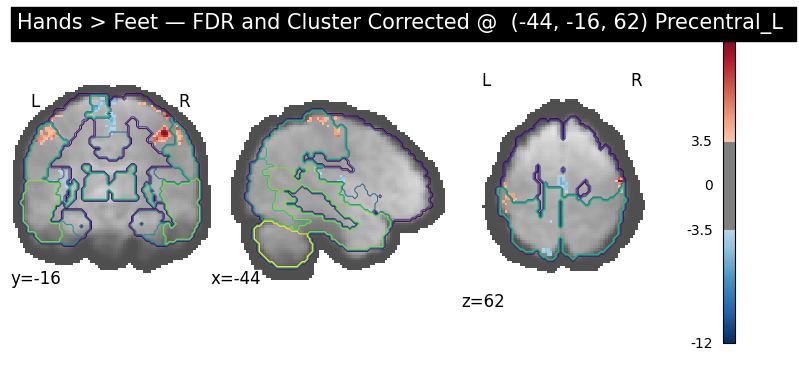

In [33]:
# Precentral_L peak at -44.0  -16.0  62.0 
display = plotting.plot_stat_map(
    hands_clean,
    bg_img=mean_image,
    threshold=hands_fdr,
    display_mode='ortho',         
    cut_coords=(-44, -16, 62), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Hands > Feet — FDR and Cluster Corrected @  (-44, -16, 62) Precentral_L "

)
display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)

##### Second Highest Peak: Postcentral L

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/2972266220.py:15: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)


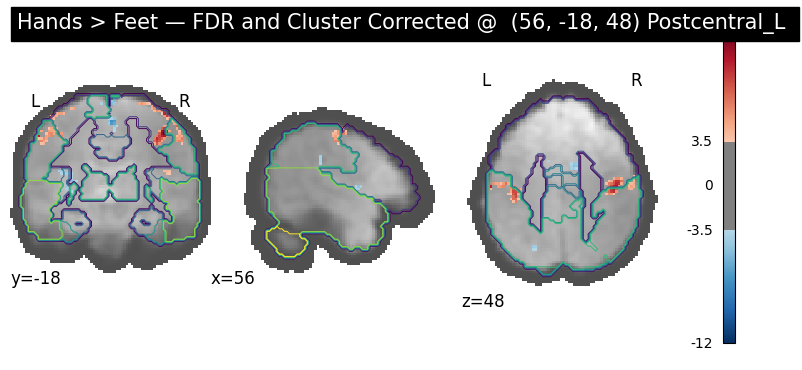

In [34]:
# Postcentral_L -56.0  -18.0  48.0

display = plotting.plot_stat_map(
    hands_clean,
    bg_img=mean_image,
    threshold=hands_fdr,
    display_mode='ortho',         
    cut_coords=(56, -18, 48), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Hands > Feet — FDR and Cluster Corrected @  (56, -18, 48) Postcentral_L " 

)
display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)


##### Postcentral R

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/2558386023.py:15: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)


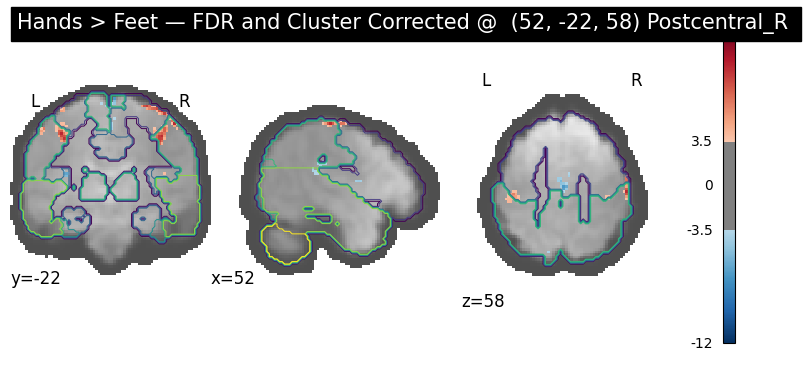

In [35]:
# Postcentral_R  52.0  -22.0  58.0 

display = plotting.plot_stat_map(
    hands_clean,
    bg_img=mean_image,
    threshold=hands_fdr,
    display_mode='ortho',         
    cut_coords=(52, -22, 58), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Hands > Feet — FDR and Cluster Corrected @  (52, -22, 58) Postcentral_R "

)
display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)


##### Cerebellum L

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/3102679809.py:15: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)


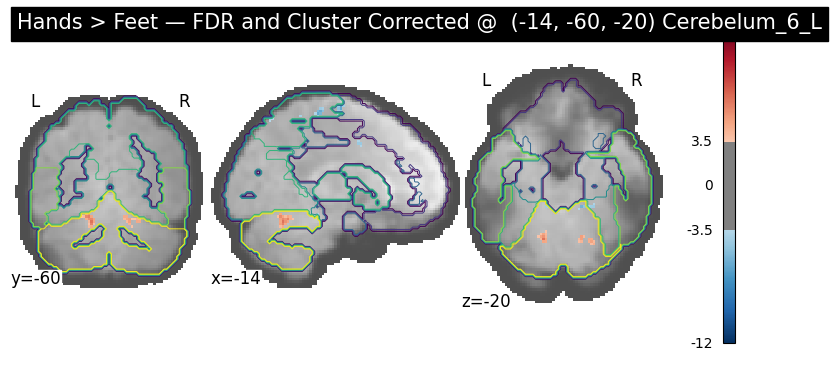

In [36]:
# Cerebelum_6_L  -14.0  -60.0 -20.0

display = plotting.plot_stat_map(
    hands_clean,
    bg_img=mean_image,
    threshold=hands_fdr,
    display_mode='ortho',         
    cut_coords=(-14, -60, -20), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Hands > Feet — FDR and Cluster Corrected @  (-14, -60, -20) Cerebelum_6_L"

)
display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)


##### Cerebellum R

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/4035877712.py:15: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)


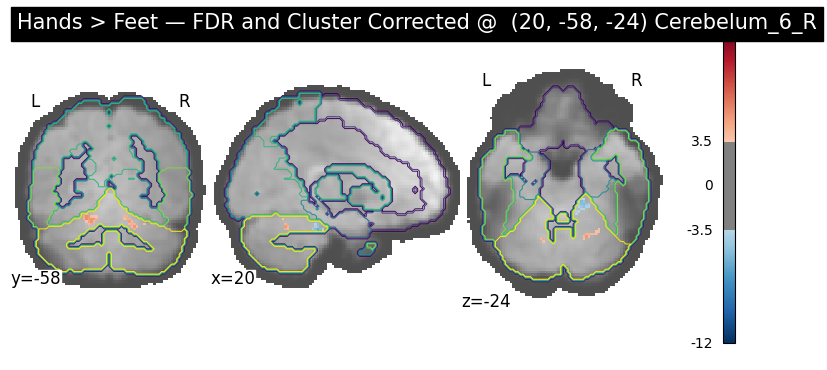

In [37]:
# Cerebelum_6_R   20.0  -58.0 -24.0 

display = plotting.plot_stat_map(
    hands_clean,
    bg_img=mean_image,
    threshold=hands_fdr,
    display_mode='ortho',         
    cut_coords=(20, -58, -24), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Hands > Feet — FDR and Cluster Corrected @  (20, -58, -24) Cerebelum_6_R"

)
display.add_contours(aal_resampled_hands, filled = False, linewidths=0.70, alpha=0.05)


#### Feet > Hands

##### Highest Peak: Supp_Motor_Area_L

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/747873992.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/747873992.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/747873992.py:16: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
 

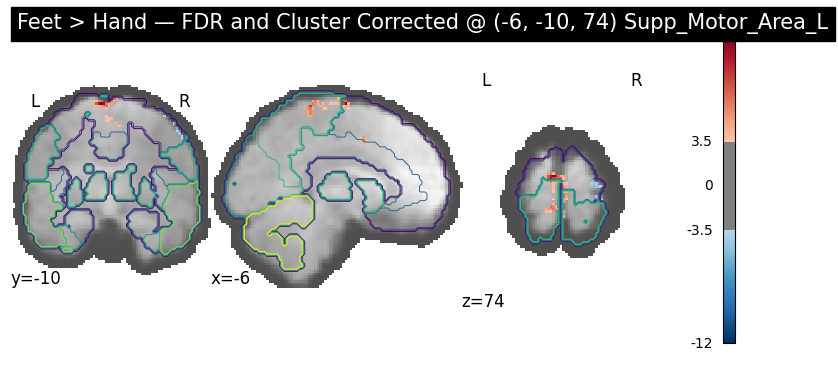

In [38]:

# Supp_Motor_Area_L (-6, -10, 74) 
aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")

display = plotting.plot_stat_map(
    feet_clean,
    bg_img=mean_image,
    threshold=feet_fdr,
    display_mode='ortho',         
    cut_coords=(-6, -10, 74), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Feet > Hand — FDR and Cluster Corrected @ (-6, -10, 74) Supp_Motor_Area_L"

)
display.add_contours(aal_resampled_feet, filled = False, linewidths=0.70, alpha=0.05)



##### Second Highest Peak: Cingulum Mid L

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/1272247124.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/1272247124.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/1272247124.py:16: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter

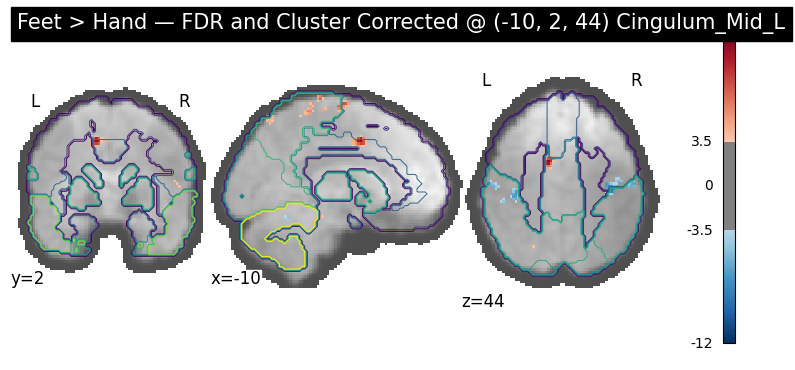

In [39]:

#Cingulum_Mid_L -10.0   2.0  44.0
aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")

display = plotting.plot_stat_map(
    feet_clean,
    bg_img=mean_image,
    threshold=feet_fdr,
    display_mode='ortho',         
    cut_coords=(-10, 2, 44), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Feet > Hand — FDR and Cluster Corrected @ (-10, 2, 44) Cingulum_Mid_L"

)
display.add_contours(aal_resampled_feet, filled = False, linewidths=0.70, alpha=0.05)



##### Cingulum_Mid_R 

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/1412928804.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/1412928804.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/1412928804.py:16: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter

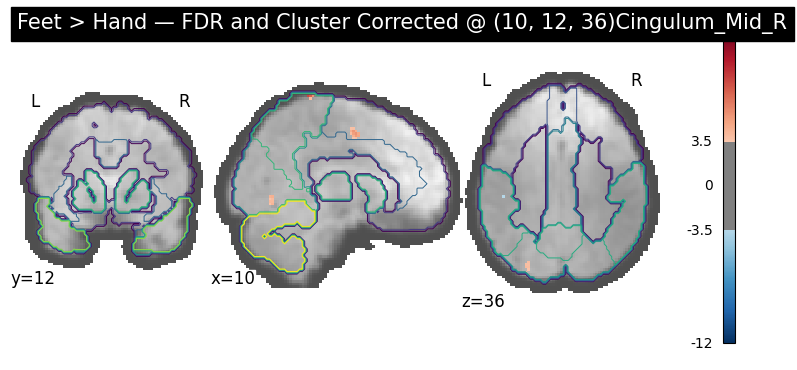

In [40]:

#Cingulum_Mid_R 10.0   12.0  36.0
aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")

display = plotting.plot_stat_map(
    feet_clean,
    bg_img=mean_image,
    threshold=feet_fdr,
    display_mode='ortho',         
    cut_coords=(10, 12, 36), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Feet > Hand — FDR and Cluster Corrected @ (10, 12, 36)Cingulum_Mid_R"

)
display.add_contours(aal_resampled_feet, filled = False, linewidths=0.70, alpha=0.05)



##### Paracentral_Lobule_L 

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/4269495186.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/4269495186.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/4269495186.py:16: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter

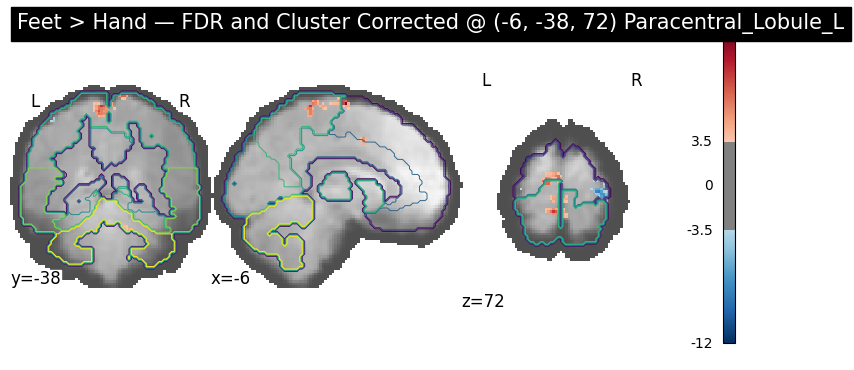

In [41]:

#Paracentral_Lobule_L -6.0 -38.0  72.0
aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")

display = plotting.plot_stat_map(
    feet_clean,
    bg_img=mean_image,
    threshold=feet_fdr,
    display_mode='ortho',         
    cut_coords=(-6, -38, 72), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Feet > Hand — FDR and Cluster Corrected @ (-6, -38, 72) Paracentral_Lobule_L"

)
display.add_contours(aal_resampled_feet, filled = False, linewidths=0.70, alpha=0.05)



##### Cerebelum_R 

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/104683931.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/104683931.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")
/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_47769/104683931.py:16: UserWarning: kwargs['alpha']=0.05 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
 

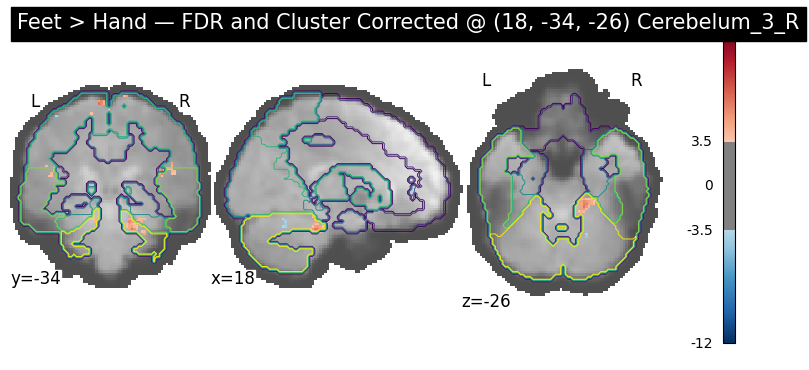

In [42]:

# Cerebelum_3_R 18.0 -34.0 -26.0
aal_resampled_feet = image.resample_to_img(aal_img, feet_clean, interpolation="nearest")

display = plotting.plot_stat_map(
    feet_clean,
    bg_img=mean_image,
    threshold=feet_fdr,
    display_mode='ortho',         
    cut_coords=(18, -34, -26), 
    draw_cross=False,            
    black_bg=False,
    annotate=True,
    title="Feet > Hand — FDR and Cluster Corrected @ (18, -34, -26) Cerebelum_3_R"

)
display.add_contours(aal_resampled_feet, filled = False, linewidths=0.70, alpha=0.05)

